In [194]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

# 메모리 변수 확인
#globals()

In [195]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
import pickle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_squared_error  # MSE RMSE
from sklearn.metrics import mean_absolute_error, r2_score # mae
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import eli5 
from eli5.sklearn import PermutationImportance 

In [196]:
df1 = pd.read_csv('data/train_메뉴제외.csv')
df3 = pd.read_csv('data/메뉴구분3.csv')

In [197]:
#plt.figure(figsize=(7,5))
#sns.heatmap(df1.corr())

## 스케일링
- y값과 카데고리 변수 제외하고 전부 스케일링

In [198]:
#x = df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월'])
#sc = StandardScaler()
#sc.fit(x)
#x = sc.transform(x)
#x

In [199]:
# 일자 드랍하고 y값 2개 뺴고 전부다 스케일링 해버리자
#df1['요일'] =  df1['요일'].astype('category') #요일을 카테고리화 하였다
#df1['요일'] = df1.요일.cat.codes #요일을 숫자로 바꿈
# 연, 월, 요일, 중식강수여부, 석시강수여부, 휴일전날, 휴일다음날 이 카데고리 전부 더미화 할지 생각해 보자
#y = df1[['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']]

#x = df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날','월']) # 카테고리컬 변수와 y값으로 쓸 변수 일자변수 빼고 전부 스케일링
#x = StandardScaler().fit_transform(x)

#x = pd.DataFrame(x,columns=df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']).columns)
#df1 =pd.concat([x,y],axis=1)

In [200]:
df1.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,식사가능인원,...,월,중식강수여부,중식기온,중식강수량,석식강수여부,석식기온,석식강수량,확진자수,휴일전날,휴일다음날
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0,2401.0,...,2,0.0,3.0,0.0,0.0,0.9,0.0,0.0,0,0
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0,2378.0,...,2,0.0,1.7,0.0,0.0,2.4,0.0,0.0,0,0


## df1 데이터 더미화

In [201]:
# 연, 월, 요일, 중식강수여부, 석시강수여부, 휴일전날, 휴일다음날 이 카데고리 전부 더미화 할지 생각해 보자
df1_cat = df1[['월', '요일']]


#df1_cat = df1[['월', '요일']]
df1_cat['월'] =  df1_cat['월'].astype('category')
df1_cat = pd.get_dummies(df1_cat[['월', '요일']])# 더미화
df1.drop(columns=['월', '요일'],inplace=True)

In [202]:
#df1 = pd.concat([df1,df1_cat],axis=1)

## 점심데이터

In [203]:
df_lunch_cat = df3.iloc[:1205]
df_lunch_cat_dummy =pd.get_dummies(df_lunch_cat.iloc[:1205][['국분류', '메뉴분류']]) # 더미화

df_lunch = pd.concat([df1,df_lunch_cat_dummy],axis=1)

In [204]:
df_lunch.head(1)

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,식사가능인원,중식결식,...,휴일다음날,국분류_국,국분류_국수,국분류_스프,국분류_찌개,국분류_탕,메뉴분류_기타,메뉴분류_육류,메뉴분류_조류,메뉴분류_해산물
0,2016-02-01,2601,50,150,238,0.0,1039.0,331.0,2401.0,1362.0,...,0,0,0,0,1,0,0,1,0,0


In [205]:
df_lunch.columns

Index(['일자', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '중식계', '석식계', '식사가능인원', '중식결식', '석식결식', '중식강수여부', '중식기온', '중식강수량',
       '석식강수여부', '석식기온', '석식강수량', '확진자수', '휴일전날', '휴일다음날', '국분류_국', '국분류_국수',
       '국분류_스프', '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류',
       '메뉴분류_해산물'],
      dtype='object')

In [206]:
x = df_lunch[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수']]
y = df_lunch.drop(columns=['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수'])
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수'])
df_lunch = pd.concat([x,y],axis=1)

In [207]:
# 일자 드랍하고 y값 2개 뺴고 전부다 스케일링 해버리자
#df1['요일'] =  df1['요일'].astype('category') #요일을 카테고리화 하였다
#df1['요일'] = df1.요일.cat.codes #요일을 숫자로 바꿈
# 연, 월, 요일, 중식강수여부, 석시강수여부, 휴일전날, 휴일다음날 이 카데고리 전부 더미화 할지 생각해 보자
#y = df1[['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']]

#x = df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날','월']) # 카테고리컬 변수와 y값으로 쓸 변수 일자변수 빼고 전부 스케일링
#x = StandardScaler().fit_transform(x)

#x = pd.DataFrame(x,columns=df1.drop(columns=['요일','중식계', '석식계','일자','중식강수여부','석식강수여부','휴일전날', '휴일다음날', '월']).columns)
#df1 =pd.concat([x,y],axis=1)

In [208]:
#sns.heatmap(df_lunch.corr())

## 저녁데이터

In [209]:
df_dinner_cat_dummy =pd.get_dummies(df3.iloc[1205:][['국분류', '메뉴분류']]) # 더미화
df_dinner_cat_duumy = pd.concat([df3.iloc[1205:]['일자'],df_dinner_cat_dummy],axis=1) # 저녁값이 비어있는곳이 있어 merge 하기 위해 일자 값 추가

df_dinner =pd.merge(df1, df_dinner_cat_duumy,on='일자',how='left')

In [210]:
df_dinner.isna().sum()

일자                 0
본사정원수              0
본사휴가자수             0
본사출장자수             0
본사시간외근무명령서승인건수     0
현본사소속재택근무자수        0
중식계                0
석식계                0
식사가능인원             0
중식결식               0
석식결식               0
중식강수여부             0
중식기온               0
중식강수량              0
석식강수여부             0
석식기온               0
석식강수량              0
확진자수               0
휴일전날               0
휴일다음날              0
국분류_국             44
국분류_국수            44
국분류_스프            44
국분류_죽             44
국분류_찌개            44
국분류_탕             44
메뉴분류_기타           44
메뉴분류_육류           44
메뉴분류_조류           44
메뉴분류_해산물          44
dtype: int64

In [211]:
#df_dinner[df_dinner.국분류_국.isna()][['일자', '석식계']]

In [212]:
#df_dinner.fillna(0,inplace=True)
df_dinner.dropna(inplace=True) #저녁안먹는날 drop

In [213]:
df_dinner[df_dinner['석식계']==0]

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,식사가능인원,중식결식,...,국분류_국,국분류_국수,국분류_스프,국분류_죽,국분류_찌개,국분류_탕,메뉴분류_기타,메뉴분류_육류,메뉴분류_조류,메뉴분류_해산물
410,2017-09-27,2642,70,265,0,0.0,1023.0,0.0,2307.0,1284.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
502,2018-02-14,2707,418,159,0,0.0,850.0,0.0,2130.0,1280.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [214]:
df_dinner = df_dinner[df_dinner['석식계']!=0]

In [215]:
df_dinner = df_dinner.reset_index()
df_dinner = df_dinner.drop(columns='index')

In [216]:
df_dinner.columns

Index(['일자', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '중식계', '석식계', '식사가능인원', '중식결식', '석식결식', '중식강수여부', '중식기온', '중식강수량',
       '석식강수여부', '석식기온', '석식강수량', '확진자수', '휴일전날', '휴일다음날', '국분류_국', '국분류_국수',
       '국분류_스프', '국분류_죽', '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류',
       '메뉴분류_해산물'],
      dtype='object')

In [217]:
x2 = df_dinner[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수']]
             
y2 = df_dinner.drop(columns=['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수'])

sc = StandardScaler().fit(x2)
x2 = sc.transform(x2)
x2 = pd.DataFrame(x2, columns=['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '중식결식',
             '석식결식','중식기온', '중식강수량', '석식기온', '석식강수량', '확진자수'])
df_dinner = pd.concat([x2,y2],axis=1)

In [218]:
#fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

#sns.boxplot(x="요일", y="중식계", hue="휴일전날", data=df_dinner, ax=ax[0])
#ax[0].set_title('중식', pad = 12)
##ax[0].legend(loc = 'lower left')
#ax[0].set_xlabel('요일')
#sns.boxplot(x="요일", y="석식계", hue="휴일전날", data=df_dinner)
#ax[1].set_title('석식', pad = 12)
#ax[1].legend(loc = 'lower left')
#ax[1].set_xlabel('요일')
#plt.show()


In [219]:
#sns.heatmap(df_dinner.corr())

## 모델링 전 X,y 나누기

### 중식

In [220]:
X = df_lunch.drop(columns=['일자','중식계','석식계','석식결식','중식결식', '석식기온', '석식강수량', '석식강수여부','현본사소속재택근무자수','중식기온'])

## 중식에 경우 ols summary에서 p_vale값이 중식기온이 유의미하지 않아 뻇다

#X = df_lunch[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
#       '식사가능인원', '중식강수여부', '중식기온', '중식강수량', '석식강수여부', '석식기온', '석식강수량', '확진자수',
#       '휴일전날', '휴일다음날']]
#X = df[['요일','본사정원수','본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','식사가능인원']] #0.43
y = df_lunch['중식계']

In [221]:
X.columns

Index(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '식사가능인원', '중식강수량',
       '확진자수', '중식강수여부', '휴일전날', '휴일다음날', '국분류_국', '국분류_국수', '국분류_스프',
       '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류', '메뉴분류_해산물'],
      dtype='object')

In [222]:
X.head(2)

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,식사가능인원,중식강수량,확진자수,중식강수여부,휴일전날,휴일다음날,국분류_국,국분류_국수,국분류_스프,국분류_찌개,국분류_탕,메뉴분류_기타,메뉴분류_육류,메뉴분류_조류,메뉴분류_해산물
0,-1.208083,-0.748721,-2.094550,-0.146735,0.202544,-0.170096,-0.283312,0.0,0,0,0,0,0,1,0,0,1,0,0
1,-1.208083,-0.748721,-1.565987,0.182349,0.072225,-0.170096,-0.283312,0.0,0,0,0,0,0,1,0,0,0,0,1


In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 석식

In [224]:
X2 = df_dinner.drop(columns=['일자','중식계','석식계','석식결식','중식결식', '중식기온', '중식강수량', '중식강수여부','석식기온', '석식강수여부', '휴일전날'])

# 석식에 경우 석식강수량과 강수여부가 휴일전날 pvaule 값이 유의미하지 않아 뺏다

#X = df[['요일','본사정원수','본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','식사가능인원']] #0.43
y2 = df_dinner['석식계']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

In [225]:
df_dinner[df_dinner.휴일전날==1]['석식계'].mean()

340.25714285714287

In [226]:
df_dinner['석식계'].mean()

478.69111302847284

In [227]:
X2.columns

Index(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원',
       '석식강수량', '확진자수', '휴일다음날', '국분류_국', '국분류_국수', '국분류_스프', '국분류_죽',
       '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류', '메뉴분류_해산물'],
      dtype='object')

In [228]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
vif = vif.sort_values('vif_factor').reset_index(drop=True)
vif

,vif_factor,feature
0,1.083694,휴일다음날
1,1.262796,휴일전날
2,1.397417,본사시간외근무명령서승인건수
3,1.465728,중식강수량
4,1.472908,중식강수여부
5,1.510301,본사출장자수
6,1.617284,확진자수
7,4.327271,본사정원수
8,4.467310,본사휴가자수
9,5.267838,식사가능인원


# 모델링

## 중식

In [229]:
import statsmodels.api as sm
#lr = sm.OLS(y,X)
#result= lr.fit() 
#print(result.summary())
#print(result.params)
#재택근무자수 무의미함 

In [230]:
data=pd.concat([X,y],axis=1)
data.columns
data_x ='+'.join(data.columns[:-1])

from statsmodels.formula.api import ols
model = ols('중식계 ~'+data_x, data)
res = model.fit()
res.summary()

# 재택근무 중식기온 p값 맞지않아 뻈다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    중식계   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     140.6
Date:                Wed, 06 Oct 2021   Prob (F-statistic):          1.07e-269
Time:                        11:38:06   Log-Likelihood:                -7485.1
No. Observations:                1205   AIC:                         1.501e+04
Df Residuals:                    1187   BIC:                         1.510e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        612.8545     12.297     49.836      0.000     588.727     636.982
본사정원수            -65.1817      7.284     -8.949      0.000     -79.472     -50.891
본사휴가자수           -49.4663      7.401     -6.684      0.000     -63.986     -34.946
본사출장자수          -109.4342      4.303    -25.432      0.000    -117.877    -100.992
본사시간외근무명령서승인건수    50.9354      4.139     12.306      0.000      42.815      59.056
식사가능인원            63.6394      8.036      7.919      0.000      47.872      79.407
중식강수량              7.2731      4.239      1.716      0.086      -1.044      15.590
확진자수              18.9378      4.453      4.253      0.000      10.201      27.674
중식강수여부            40.2118     15.266      2.634      0.009      10.260      70.164
휴일전날             -59.6537     22.515     -2.650      0.008    -103.828     -15.480
휴일다음날             77.6230     20.106      3.861      0.000      38.176     117.070
국분류_국            121.4266     15.773      7.698      0.000      90.480     152.373
국분류_국수           141.0226     18.841      7.485      0.000     104.056     177.989
국분류_스프           156.2513     71.632      2.181      0.029      15.712     296.790
국분류_찌개            98.0514     16.923      5.794      0.000      64.848     131.255
국분류_탕             96.1025     16.709      5.752      0.000      63.320     128.885
메뉴분류_기타          165.2700     12.189     13.559      0.000     141.355     189.184
메뉴분류_육류          175.5290      6.403     27.413      0.000     162.966     188.092
메뉴분류_조류          142.6595      8.301     17.186      0.000     126.373     158.946
메뉴분류_해산물         129.3960      7.604     17.017      0.000     114.477     144.315
==============================================================================
Omnibus:                        2.466   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                2.567
Skew:                          -0.026   Prob(JB):                        0.277
Kurtosis:                       3.220   Cond. No.                     1.04e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.09e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 석식

In [231]:
#lr = sm.OLS(y2,X2)
#result= lr.fit() 
#print(result.summary())
#print(result.params)
# 저녁은 확진자수, 강수, 강수여부

In [232]:
data=pd.concat([X2,y2],axis=1)
data.columns
data_x ='+'.join(data.columns[:-1])

model = ols('석식계 ~'+data_x, data)
res = model.fit()
res.summary()  

# 석식기온, 석식 강수여부

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    석식계   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     85.40
Date:                Wed, 06 Oct 2021   Prob (F-statistic):          4.47e-182
Time:                        11:38:06   Log-Likelihood:                -6626.6
No. Observations:                1159   AIC:                         1.329e+04
Df Residuals:                    1142   BIC:                         1.337e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        350.2499      9.048     38.710      0.000     332.497     368.002
본사정원수            -27.8657      1.622    -17.182      0.000     -31.048     -24.684
본사휴가자수           -29.4627      1.946    -15.143      0.000     -33.280     -25.645
본사출장자수           -18.4324      2.584     -7.135      0.000     -23.501     -13.363
본사시간외근무명령서승인건수    53.9415      2.639     20.443      0.000      48.764      59.119
현본사소속재택근무자수      -12.2431      2.500     -4.897      0.000     -17.149      -7.337
식사가능인원             9.3482      1.734      5.392      0.000       5.946      12.750
석식강수량              5.7516      2.197      2.617      0.009       1.440      10.063
확진자수               0.1311      2.765      0.047      0.962      -5.293       5.556
휴일다음날             37.9386     12.391      3.062      0.002      13.626      62.251
국분류_국             39.9654     11.578      3.452      0.001      17.249      62.682
국분류_국수            40.8898     12.711      3.217      0.001      15.950      65.830
국분류_스프            34.4049     15.750      2.184      0.029       3.502      65.308
국분류_죽            161.8128     63.935      2.531      0.012      36.370     287.256
국분류_찌개            42.1768     12.219      3.452      0.001      18.202      66.152
국분류_탕             31.0002     12.252      2.530      0.012       6.962      55.039
메뉴분류_기타           80.1578      4.829     16.600      0.000      70.683      89.632
메뉴분류_육류           95.0858      4.142     22.958      0.000      86.959     103.212
메뉴분류_조류           92.9245      5.775     16.090      0.000      81.593     104.256
메뉴분류_해산물          82.0818      4.350     18.869      0.000      73.547      90.617
==============================================================================
Omnibus:                       58.190   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.740
Skew:                          -0.183   Prob(JB):                     2.28e-37
Kurtosis:                       4.833   Cond. No.                     9.53e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.84e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 릿지

### 점심

In [233]:
from sklearn.linear_model import Ridge

param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Ridge(),param_grid, cv=5, scoring='r2')
gird_search.fit(X_train,y_train)
pre =gird_search.predict(X_test)

print(gird_search.best_params_)
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))
print('r2score=',r2_score(y_test, pre))




{'alpha': 10}
RMSE= 123.18069766238233
MAE= 96.51013295994551
r2score= 0.6490244742821681


In [240]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli = eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(5)


<AxesSubplot:xlabel='feature', ylabel='weight'>

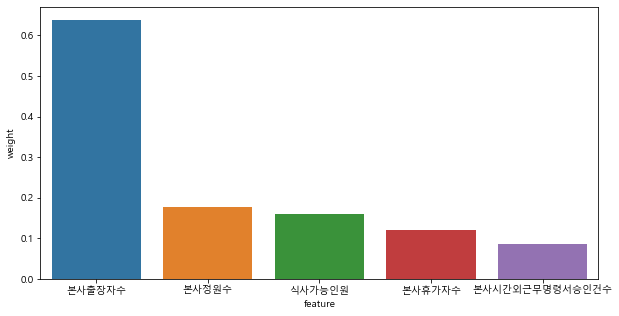

In [244]:
plt.figure(figsize=(10,5))
sns.barplot(data=eli, x='feature', y='weight')

In [ ]:
eli5

,feature,weight,std
0,본사출장자수,0.638728,0.013588
1,본사정원수,0.177111,0.018881
2,식사가능인원,0.159608,0.008201
3,본사휴가자수,0.119368,0.012288
4,본사시간외근무명령서승인건수,0.085949,0.008542
5,확진자수,0.015111,0.002469
6,휴일다음날,0.009955,0.002522
7,메뉴분류_육류,0.006343,0.001538
8,국분류_탕,0.005343,0.001704
9,메뉴분류_해산물,0.005020,0.002191


### 저녁

In [ ]:
from sklearn.linear_model import Ridge

param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Ridge(),param_grid, cv=5, scoring='neg_mean_absolute_error')

gird_search.fit(X2_train,y2_train)
pre =gird_search.predict(X2_test)
print(gird_search.best_params_)

print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))
print('r2score=',r2_score(y2_test, pre))

{'alpha': 1}
RMSE= 63.155372016313024
MAE= 49.31556906169137
r2score= 0.6487526886059538


In [ ]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X2_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,50.049113,2.529607
1,본사정원수,15.419605,0.725768
2,본사휴가자수,12.892925,0.644951
3,본사출장자수,9.272755,0.540576
4,요일_금,7.035980,0.471004
5,현본사소속재택근무자수,3.655122,0.371951
6,월_8,3.361208,0.322418
7,월_12,3.250689,0.293611
8,식사가능인원,2.673621,0.295137
9,요일_목,2.611485,0.244310


## 라쏘

### 점심

In [ ]:
from sklearn.linear_model import Lasso #라쏘


param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Lasso(),param_grid, cv=5, scoring='r2')
gird_search.fit(X_train,y_train)
pre =gird_search.predict(X2_test)

gird_search = GridSearchCV(Lasso(),param_grid, cv=5, scoring='r2')
gird_search.fit(X2_train,y2_train)
pre =gird_search.predict(X2_test)

pre =gird_search.predict(X_test)

print(gird_search.best_params_)

print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))
print('r2score=',r2_score(y_test, pre))

{'alpha': 0.01}
RMSE= 433.3055514009402
MAE= 401.74861600353813
r2score= -3.342901911572741


In [ ]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,0.314844,0.031691
1,본사휴가자수,0.161310,0.011405
2,본사출장자수,0.146798,0.003913
3,요일_금,0.015542,0.000756
4,본사정원수,0.014842,0.000897
5,월_11,0.006430,0.001544
6,월_8,0.005730,0.000643
7,월_2,0.004677,0.001244
8,메뉴분류_육류,0.003307,0.000606
9,확진자수,0.002979,0.000606


In [ ]:
'''from sklearn.linear_model import Lasso #라쏘
for alpha in [0.1, 0.5, 1, 10, 100]:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X_train, y_train)
    
    pre =model_lasso.predict(X_test)
    
    print(f'--------------alpha{alpha}값----------------')
    print('R2score=',model_lasso.score(X_test, y_test)) #R2값 1일수록 좋은것
    print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
    print('MAE=',mean_absolute_error(y_test, pre))


model_lasso = Lasso(alpha=1)
model_lasso.fit(X_train, y_train)
pre =model_lasso.predict(X_test)

plt.figure(figsize=(10,5))
sns.kdeplot(y_test, label='y_test')
sns.kdeplot(pre, label='y_hat')

plt.title(f'alpha값 {1}일때')
plt.legend()
plt.show()  
'''


"from sklearn.linear_model import Lasso #라쏘\nfor alpha in [0.1, 0.5, 1, 10, 100]:\n    model_lasso = Lasso(alpha=alpha)\n    model_lasso.fit(X_train, y_train)\n    \n    pre =model_lasso.predict(X_test)\n    \n    print(f'--------------alpha{alpha}값----------------')\n    print('R2score=',model_lasso.score(X_test, y_test)) #R2값 1일수록 좋은것\n    print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))\n    print('MAE=',mean_absolute_error(y_test, pre))\n\n\nmodel_lasso = Lasso(alpha=1)\nmodel_lasso.fit(X_train, y_train)\npre =model_lasso.predict(X_test)\n\nplt.figure(figsize=(10,5))\nsns.kdeplot(y_test, label='y_test')\nsns.kdeplot(pre, label='y_hat')\n\nplt.title(f'alpha값 {1}일때')\nplt.legend()\nplt.show()  \n"

### 저녁

In [ ]:

param_grid = {'alpha':[0.001, 0.01, 0.1, 1,10,50]}
gird_search = GridSearchCV(Lasso(),param_grid, cv=5, scoring='neg_mean_absolute_error')

gird_search.fit(X2_train,y2_train)
pre =gird_search.predict(X2_test)

print(gird_search.best_params_)
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))
print('r2score=',r2_score(y2_test, pre))

{'alpha': 0.01}
RMSE= 63.22708230215269
MAE= 49.36447626468728
r2score= 0.647954582466058


In [ ]:
perm = PermutationImportance(gird_search, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,50.833460,2.537343
1,본사휴가자수,19.652746,0.887401
2,본사출장자수,11.497003,0.640282
3,요일_금,11.262762,0.498614
4,현본사소속재택근무자수,7.607804,0.464261
5,본사정원수,7.070929,0.373879
6,요일_수,4.370858,0.411005
7,월_12,3.444808,0.291115
8,월_8,3.265184,0.322816
9,월_1,2.391362,0.390211


In [ ]:
'''for alpha in [0.1, 0.5, 1, 10, 100]:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X2_train, y2_train)
    
    pre =model_lasso.predict(X2_test)
    pre =np.round(pre,0)

    print(f'--------------alpha{alpha}값----------------')
    print(model_lasso.score(X2_test, y2_test))
    print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
    print('MAE=',mean_absolute_error(y2_test, pre))

model_lasso = Lasso(alpha=0.5)
model_lasso.fit(X2_train, y2_train)
print(model_lasso.score(X2_test, y2_test))
pre =model_lasso.predict(X2_test)
pre =np.round(pre,0)
plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y2_test, label='y_test')
ax2 = sns.kdeplot(pre, label='y_hat', ax=ax1)
plt.title(f'alpha값 {0.5}일때')
plt.legend()
plt.show()'''

"for alpha in [0.1, 0.5, 1, 10, 100]:\n    model_lasso = Lasso(alpha=alpha)\n    model_lasso.fit(X2_train, y2_train)\n    \n    pre =model_lasso.predict(X2_test)\n    pre =np.round(pre,0)\n\n    print(f'--------------alpha{alpha}값----------------')\n    print(model_lasso.score(X2_test, y2_test))\n    print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))\n    print('MAE=',mean_absolute_error(y2_test, pre))\n\nmodel_lasso = Lasso(alpha=0.5)\nmodel_lasso.fit(X2_train, y2_train)\nprint(model_lasso.score(X2_test, y2_test))\npre =model_lasso.predict(X2_test)\npre =np.round(pre,0)\nplt.figure(figsize=(10,5))\nax1 = sns.kdeplot(y2_test, label='y_test')\nax2 = sns.kdeplot(pre, label='y_hat', ax=ax1)\nplt.title(f'alpha값 {0.5}일때')\nplt.legend()\nplt.show()"

## SVM

In [ ]:
from sklearn import svm

### 점심

In [ ]:
'''
clf = svm.SVC(kernel = 'linear') #다른파라메터 넣어봐도 큰 변화 없음 gamma 등
clf.fit(X_train,y_train)
pre_clf =clf.predict(X_test)

print('r2=',r2_score(y_test,pre_clf))
print('RMSE=',np.sqrt(np.sqrt(mean_squared_error(y_test, pre_clf))))
print('MAE=',mean_absolute_error(y_test, pre_clf))

plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y_test, label='y_test')
ax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)
plt.legend()
plt.show()'''

"\nclf = svm.SVC(kernel = 'linear') #다른파라메터 넣어봐도 큰 변화 없음 gamma 등\nclf.fit(X_train,y_train)\npre_clf =clf.predict(X_test)\n\nprint('r2=',r2_score(y_test,pre_clf))\nprint('RMSE=',np.sqrt(np.sqrt(mean_squared_error(y_test, pre_clf))))\nprint('MAE=',mean_absolute_error(y_test, pre_clf))\n\nplt.figure(figsize=(10,5))\nax1 = sns.kdeplot(y_test, label='y_test')\nax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)\nplt.legend()\nplt.show()"

### 저녁

In [ ]:
'''clf = svm.SVC(kernel = 'linear', max_iter=-1)
clf.fit(X2_train,y2_train)
pre_clf =clf.predict(X2_test)

print('r2=',r2_score(y2_test,pre_clf))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre_clf)))
print('MAE=',mean_absolute_error(y2_test, pre_clf))

plt.figure(figsize=(10,5))
ax1 = sns.kdeplot(y2_test, label='y_test')
ax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)
plt.legend()
plt.show()'''

"clf = svm.SVC(kernel = 'linear', max_iter=-1)\nclf.fit(X2_train,y2_train)\npre_clf =clf.predict(X2_test)\n\nprint('r2=',r2_score(y2_test,pre_clf))\nprint('RMSE=',np.sqrt(mean_squared_error(y2_test, pre_clf)))\nprint('MAE=',mean_absolute_error(y2_test, pre_clf))\n\nplt.figure(figsize=(10,5))\nax1 = sns.kdeplot(y2_test, label='y_test')\nax2 = sns.kdeplot(pre_clf, label='y_hat', ax=ax1)\nplt.legend()\nplt.show()"

## xgboost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

### 점식

In [ ]:
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
pre = grid_search.predict(X_test)
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X2_train, y2_train)
pre = grid_search.predict(X2_test)

print(grid_search.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

with open('model_rf/XG_lunch_estimator.pickle','wb') as fw: #저장
    pickle.dump(grid_search.best_estimator_, fw)

ValueError: feature_names mismatch: ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '식사가능인원', '석식강수량', '확진자수', '휴일다음날', '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10', '월_11', '월_12', '요일_금', '요일_목', '요일_수', '요일_월', '요일_화', '국분류_국', '국분류_국수', '국분류_스프', '국분류_죽', '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류', '메뉴분류_해산물'] ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '식사가능인원', '중식강수량', '확진자수', '중식강수여부', '휴일전날', '휴일다음날', '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10', '월_11', '월_12', '요일_금', '요일_목', '요일_수', '요일_월', '요일_화', '국분류_국', '국분류_국수', '국분류_스프', '국분류_찌개', '국분류_탕', '메뉴분류_기타', '메뉴분류_육류', '메뉴분류_조류', '메뉴분류_해산물']
expected 석식강수량, 현본사소속재택근무자수, 국분류_죽 in input data
training data did not have the following fields: 중식강수량, 휴일전날, 중식강수여부

In [ ]:

grid_search.best_params_

{'colsample_bylevel': 0.7,
 'colsample_bytree': 0.5,
 'max_depth': 2,
 'n_estimators': 300}

In [ ]:
with open('model_rf/XG_lunch_estimator.pickle','rb') as f: #불러오기
    XG_lunch_model = pickle.load(f)

In [ ]:
XG_lunch_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XG_lunch_model.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
pre = XG_lunch_model.predict(X_test)
print(XG_lunch_model.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

0.820623628744095
RMSE= 88.06165839407906
MAE= 64.36262432119464


In [ ]:
perm = PermutationImportance(XG_lunch_model, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,본사출장자수,0.269204,0.010877
1,요일_월,0.250399,0.010867
2,본사휴가자수,0.150813,0.004657
3,식사가능인원,0.072492,0.004429
4,본사정원수,0.071161,0.003537
5,본사시간외근무명령서승인건수,0.058158,0.002367
6,요일_금,0.051481,0.001680
7,확진자수,0.037091,0.002455
8,휴일다음날,0.033872,0.002154
9,월_12,0.031799,0.001041


저녁

In [ ]:
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X2_train, y2_train)

pre = grid_search.predict(X2_test)

print(grid_search.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

with open('model_rf/XG_dinner_estimator.pickle','wb') as fw: ##저장
    pickle.dump(grid_search.best_estimator_, fw)


-4268.97373460308
RMSE= 65.33738389775856
MAE= 48.11164439409629


In [ ]:
grid_search.best_params_

{'colsample_bylevel': 1,
 'colsample_bytree': 0.7,
 'max_depth': 2,
 'n_estimators': 300}

In [ ]:
with open('model_rf/XG_dinner_estimator.pickle','rb') as f:
    XG_dinner_model = pickle.load(f)

In [ ]:
XG_dinner_model =XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1,monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XG_dinner_model.fit(X2_train,y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
pre = XG_dinner_model.predict(X2_test)
print(XG_dinner_model.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

0.6408490731287577
RMSE= 63.86196672444343
MAE= 48.09025595654016


In [ ]:
perm = PermutationImportance(XG_dinner_model, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,0.663358,0.036235
1,본사휴가자수,0.256636,0.008511
2,본사출장자수,0.168433,0.007923
3,본사정원수,0.121480,0.006093
4,요일_금,0.075122,0.002334
5,식사가능인원,0.074781,0.002498
6,월_12,0.074249,0.003079
7,현본사소속재택근무자수,0.050390,0.004844
8,월_1,0.035741,0.003441
9,확진자수,0.028792,0.001306


## 랜덤포레스트 모델

## 점심 저녁 한번예

In [ ]:

params = {#max_depth=10, n_estimators=50, n_jobs=-1, random_state=42
    'n_estimators': [50,100,150,300,1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [1,3,6,10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 5, 10]}

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

RF_lunch_model = GridSearchCV(model1, params, scoring='r2')
RF_dinner_model = GridSearchCV(model2, params, scoring='r2')

RF_lunch_model.fit(X_train, y_train)
RF_dinner_model.fit(X2_train, y2_train)
RF_lunch_model.fit(X_train,y_train)
RF_dinner_model.fit(X2_train, y2_train)

RF_lunch_best = RF_lunch_model.best_score_
RF_dinner_best = RF_dinner_model.best_score_

print('점심 RF 모델 에러값(mae) : ',RF_lunch_best)
print('저녁 RF 모델 에러값(mae) : ',RF_dinner_best)

rf_lunch_param=RF_lunch_model.best_params_
rf_lunch_est = RF_lunch_model.best_estimator_

rf_dinner_param=RF_dinner_model.best_params_
rf_lunch_est = RF_dinner_model.best_estimator_

with open('model_rf/rf_lunch_estimator.pickle','wb') as fw:
    pickle.dump(RF_lunch_model.best_estimator_, fw)
with open('model_rf/rf_dinner_estimator.pickle','wb') as fw:
    pickle.dump(RF_dinner_model.best_estimator_, fw)
# 모델값저장



"\nparams = {#max_depth=10, n_estimators=50, n_jobs=-1, random_state=42\n    'n_estimators': [50,100,150,300,1000],\n    'max_features': ['auto', 'sqrt'],\n    'max_depth' : [1,3,6,10],\n    'min_samples_leaf': [1, 2, 4],\n    'min_samples_split': [2, 3, 5, 10]}\n\nmodel1 = RandomForestRegressor(n_jobs=-1, random_state=42)\nmodel2 = RandomForestRegressor(n_jobs=-1, random_state=42)\n\nRF_lunch_model = GridSearchCV(model1, params, scoring='neg_mean_absolute_error')\nRF_dinner_model = GridSearchCV(model2, params, scoring='neg_mean_absolute_error')\n\nRF_lunch_model.fit(X_train, y_train)\nRF_dinner_model.fit(X2_train, y2_train)\n\nRF_lunch_best = RF_lunch_model.best_score_\nRF_dinner_best = RF_dinner_model.best_score_\n\nprint('점심 RF 모델 에러값(mae) : ',RF_lunch_best)\nprint('저녁 RF 모델 에러값(mae) : ',RF_dinner_best)\n\nrf_lunch_param=RF_lunch_model.best_params_\nrf_lunch_est = RF_lunch_model.best_estimator_\n\nrf_dinner_param=RF_dinner_model.best_params_\nrf_lunch_est = RF_dinner_model.best_esti

In [ ]:
'''print(rf_lunch_param, rf_lunch_est, rf_dinner_param, rf_lunch_est)'''

'print(rf_lunch_param, rf_lunch_est, rf_dinner_param, rf_lunch_est)'

In [ ]:
with open('model_rf/rf_lunch_estimator.pickle','rb') as f:
    RF_lunch_model = pickle.load(f)
with open('model_rf/rf_dinner_estimator.pickle','rb') as f:
    RF_dinner_model = pickle.load(f)
RF_lunch_model.fit(X_train,y_train)
RF_dinner_model.fit(X2_train, y2_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [ ]:
RF_lunch_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [ ]:
RF_dinner_model.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
pre_lunch = RF_lunch_model.predict(X_test)
pre_dinner = RF_dinner_model.predict(X2_test)
print('-----------점심 ------------')
print(RF_lunch_model.score(X_test,y_test))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre_lunch)))
print('MAE=',mean_absolute_error(y_test, pre_lunch))
print('-----------저녁---------------')
print(RF_dinner_model.score(X2_test,y2_test))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre_dinner)))
print('MAE=',mean_absolute_error(y2_test, pre_dinner))

-----------점심 ------------
0.8323624938331273
RMSE= 85.13141237415594
MAE= 63.795444242030214
-----------저녁---------------
0.6610801505316504
RMSE= 62.03721539125452
MAE= 45.99761604044308


In [ ]:
perm = PermutationImportance(RF_lunch_model, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,요일_월,0.446502,0.026361
1,본사출장자수,0.288116,0.015916
2,본사휴가자수,0.225662,0.007488
3,요일_금,0.118545,0.009149
4,본사시간외근무명령서승인건수,0.115698,0.010497
5,본사정원수,0.035525,0.002484
6,식사가능인원,0.024526,0.001981
7,휴일다음날,0.024141,0.002430
8,월_10,0.010975,0.001025
9,확진자수,0.010674,0.000702


In [ ]:
perm = PermutationImportance(RF_dinner_model, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,0.884046,0.060689
1,본사휴가자수,0.234774,0.018027
2,본사정원수,0.206388,0.006263
3,본사출장자수,0.170634,0.004892
4,확진자수,0.059964,0.002207
5,식사가능인원,0.039942,0.001695
6,현본사소속재택근무자수,0.039199,0.002518
7,월_12,0.027772,0.002080
8,요일_목,0.023281,0.002032
9,월_10,0.012664,0.002597


## KNN

## 점심

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

grid_model = GridSearchCV(KNeighborsRegressor(), grid_params, scoring='r2')
grid_model.fit(X_train, y_train) 
pre = grid_model.predict(X_test)

grid_model = GridSearchCV(KNeighborsRegressor(), grid_params, scoring='r2')
grid_model.fit(X2_train, y2_train) 
pre = grid_model.predict(X2_test)

print(grid_model.score(X_test,y_test))
print('r2=',r2_score(y_test,pre))
print('RMSE=',np.sqrt(mean_squared_error(y_test, pre)))
print('MAE=',mean_absolute_error(y_test, pre))

-69.54801687133468
r2= 0.8087948425701841
RMSE= 90.91887307938624
MAE= 69.54801687133468


In [ ]:
grid_model.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

In [ ]:
perm = PermutationImportance(grid_model, random_state = 42).fit(X_train,y_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X_train.columns.tolist()).head(10)

,feature,weight,std
0,본사출장자수,57.991399,1.291253
1,본사시간외근무명령서승인건수,48.270025,1.523636
2,본사정원수,44.563374,1.343998
3,식사가능인원,44.512455,0.780623
4,본사휴가자수,42.923524,0.461634
5,메뉴분류_육류,23.974265,0.786766
6,요일_월,23.935546,0.878174
7,국분류_국,22.716896,1.163407
8,요일_목,19.714982,0.531487
9,요일_화,17.886177,0.957471


## 저녁

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

grid_model = GridSearchCV(KNeighborsRegressor(), grid_params, scoring='neg_mean_absolute_error')

grid_model.fit(X2_train, y2_train) 
pre = grid_model.predict(X2_test)

print(grid_model.score(X2_test,y2_test))
print('r2=',r2_score(y2_test,pre))
print('RMSE=',np.sqrt(mean_squared_error(y2_test, pre)))
print('MAE=',mean_absolute_error(y2_test, pre))

-49.6265365878378
r2= 0.6083902730095437
RMSE= 66.68536438602632
MAE= 49.6265365878378


In [ ]:
grid_model.best_estimator_

KNeighborsRegressor(metric='euclidean', n_neighbors=4, weights='distance')

In [ ]:
perm = PermutationImportance(grid_model, random_state = 42).fit(X2_train,y2_train) 
#eli5.show_weights(perm, top = 20, feature_names = X_train.columns.tolist(),include_styles=True)
eli5.explain_weights_df(perm,feature_names= X2_train.columns.tolist()).head(10)

,feature,weight,std
0,본사시간외근무명령서승인건수,43.911589,2.166999
1,본사출장자수,38.641065,0.534752
2,본사정원수,36.685020,1.201005
3,본사휴가자수,32.314677,0.704343
4,식사가능인원,31.576901,1.133214
5,현본사소속재택근무자수,19.115921,0.751412
6,메뉴분류_육류,16.880567,0.855490
7,국분류_국,16.694165,0.373019
8,메뉴분류_해산물,15.609525,0.453115
9,확진자수,11.981971,0.270058
